In [5]:
import pandas as pd

# Load the dataset
OverseasResidentsDataPath = 'OverseasResidents_CleanedData.csv'  # Replace with your actual file path
TravelTrends_df = pd.read_csv(OverseasResidentsDataPath)
RegionBasedDataPath = 'RegionBased_TravelTrends.csv'
CountryBasedDataPath = 'CountryBasedUpdated_TravelTrends.csv'
RegionBasedTravelTrends_df = pd.read_csv(RegionBasedDataPath)
CountryBasedTravelTrends_df = pd.read_csv(CountryBasedDataPath)

Index(['Total Visits', 'Total Spending in millions', 'Nights Spent', 'Year',
       'Visits by Purpose', 'Spending in millions', 'Number of visits by Air',
       'Number of visits by Sea and Tunnel'],
      dtype='object')
Fitting 3 folds for each of 10 candidates, totalling 30 fits


C:\Users\vaibh\AppData\Local\Temp\ipykernel_40564\2725796807.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['Area of Residence'] = label_encoder_residence.fit_transform(filtered_data['Area of Residence'])
C:\Users\vaibh\AppData\Local\Temp\ipykernel_40564\2725796807.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['Purpose of Visit'] = label_encoder_purpose.fit_transform(filtered_data['Purpose of Visit'])
C:\Users\vaibh\AppData\Local\Temp\ipykernel_40564\2725796807.py:29

Test R^2: 0.9109440962042824
Test RMSE: 181.01716832920152
Test MAE: 88.28863919986729
                             Area and Purpose  \
0               North America - Holiday - All   
1    North America - Holiday - Inclusive tour   
2                    North America - Business   
3  North America - Visit friends or relatives   
4               North America - Miscellaneous   

   Predicted Spending (in millions)  
0                       7994.262549  
1                       1348.451761  
2                       2969.001980  
3                       4533.001851  
4                       2246.264848  
Train R^2: 0.9230646674998196
Train RMSE: 167.9914005819908
Train MAE: 65.06998746902505


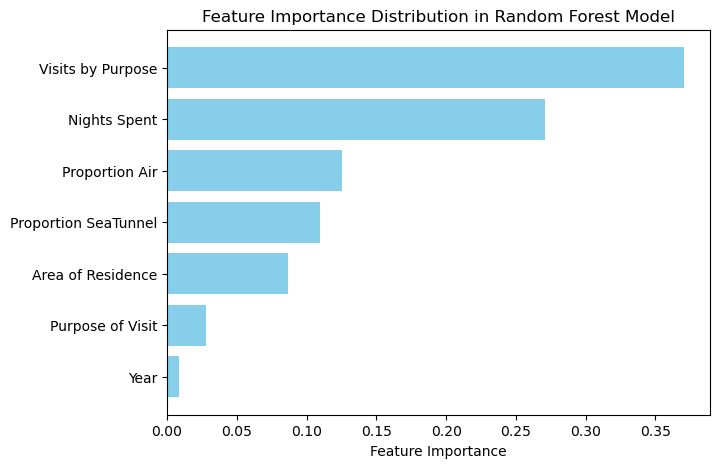

In [6]:
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import matplotlib.pyplot as plt
import numpy as np

# Load Data
data = TravelTrends_df

# Fill all numerical columns with 0 for the year 2020
numerical_columns = data.select_dtypes(include='number').columns
print(numerical_columns)
data.loc[data['Year'] == '2020', numerical_columns] = 0

# Filter out data to include only quarterly data (Q1, Q2, Q3, Q4) and exclude "World Total"
filtered_data = TravelTrends_df[(TravelTrends_df['Quarter'].isin(['Q1', 'Q2', 'Q3', 'Q4'])) & (TravelTrends_df['Purpose of Visit'] != 'All visits')]

# Initialize the label encoder for 'Area of Residence' and 'Purpose of Visit'
label_encoder_residence = LabelEncoder()
label_encoder_purpose = LabelEncoder()

# Encode 'Area of Residence' and 'Purpose of Visit'
filtered_data['Area of Residence'] = label_encoder_residence.fit_transform(filtered_data['Area of Residence'])
filtered_data['Purpose of Visit'] = label_encoder_purpose.fit_transform(filtered_data['Purpose of Visit'])

# Feature Engineering: Create a proportion feature
filtered_data['Proportion Air'] = filtered_data['Number of visits by Air'] / filtered_data['Total Visits']
filtered_data['Proportion SeaTunnel'] = filtered_data['Number of visits by Sea and Tunnel'] / filtered_data['Total Visits']

# Define Features and Target without 'Total Visits'
features = ['Area of Residence', 'Nights Spent', 'Purpose of Visit', 
            'Visits by Purpose', 'Proportion Air', 'Proportion SeaTunnel', 'Year']
X = filtered_data[features]
y = filtered_data['Spending in millions']

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.4, random_state=42)

# Fine-tuned Hyperparameter Tuning with RandomizedSearchCV
param_dist = {
    'n_estimators': [50, 100],
    'max_depth': [5, 10],  # Reduced depth for less complexity
    'min_samples_split': [10, 30],  # Increased to prevent overfitting
    'min_samples_leaf': [5, 15],  # Increased to control tree size
    'max_features': ['sqrt']
}

rf = RandomForestRegressor(random_state=42)
random_search = RandomizedSearchCV(estimator=rf, param_distributions=param_dist, 
                                   n_iter=10, cv=3, verbose=2, n_jobs=-1, random_state=42)
random_search.fit(X_train, y_train)

# Best parameters from Randomized Search
best_rf = random_search.best_estimator_

# Train the model on the training dataset
best_rf.fit(X_train, y_train)

# Predict on the test set
y_test_pred = best_rf.predict(X_test)

# Evaluate the Model on the Test Set
test_r2 = r2_score(y_test, y_test_pred)
test_rmse = mean_squared_error(y_test, y_test_pred, squared=False)
test_mae = mean_absolute_error(y_test, y_test_pred)
print("Test R^2:", test_r2)
print("Test RMSE:", test_rmse)
print("Test MAE:", test_mae) 

# Predict for 2024 using the entire dataset
X_2024 = X.copy()
X_2024['Year'] = 2024  # Adjust Year for prediction
X_2024_scaled = scaler.transform(X_2024)
y_2024_pred = best_rf.predict(X_2024_scaled)

# Aggregate Predictions by Area of Residence and Purpose of Visit
predictions_by_area_purpose = {}
for region in filtered_data['Area of Residence'].unique():
    for purpose in filtered_data['Purpose of Visit'].unique():
        region_name = label_encoder_residence.inverse_transform([region])[0]
        purpose_name = label_encoder_purpose.inverse_transform([purpose])[0]
        key = f"{region_name} - {purpose_name}"
        
        predictions_by_area_purpose[key] = y_2024_pred[
            (filtered_data['Area of Residence'] == region) & 
            (filtered_data['Purpose of Visit'] == purpose)].sum()

# Convert the predictions dictionary to a DataFrame for tabular output
df_predictions = pd.DataFrame(list(predictions_by_area_purpose.items()), columns=['Area and Purpose', 'Predicted Spending (in millions)'])

# Output the results in tabular form
print(df_predictions.head())
# Save the updated data to a new CSV file
output_path = 'C://Users/vaibh/OneDrive/Desktop/BUSINESSPROJECT/PredictedData.csv'
df_predictions.to_csv(output_path, index=False)

# Evaluate the Model on the Training Set
y_train_pred = best_rf.predict(X_train)
train_r2 = r2_score(y_train, y_train_pred)
train_rmse = mean_squared_error(y_train, y_train_pred, squared=False)
train_mae = mean_absolute_error(y_train, y_train_pred)
print("Train R^2:", train_r2)
print("Train RMSE:", train_rmse)
print("Train MAE:", train_mae)

# Feature Importance Analysis
feature_importances = best_rf.feature_importances_
features = np.array(['Area of Residence', 'Nights Spent', 'Purpose of Visit', 
                     'Visits by Purpose', 'Proportion Air', 'Proportion SeaTunnel', 'Year'])

# Sort the feature importances in descending order
sorted_idx = np.argsort(feature_importances)[::-1]

# Plot the feature importances
plt.figure(figsize=(7, 5))
plt.barh(features[sorted_idx], feature_importances[sorted_idx], color='skyblue')
plt.xlabel('Feature Importance')
plt.title('Feature Importance Distribution in Random Forest Model')
plt.gca().invert_yaxis()  # Invert y-axis to show the most important feature at the top
plt.show()


C:\Users\vaibh\AppData\Local\Temp\ipykernel_40564\1506813643.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['Area of Residence'] = label_encoder_residence.fit_transform(filtered_data['Area of Residence'])
C:\Users\vaibh\AppData\Local\Temp\ipykernel_40564\1506813643.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['Purpose of Visit'] = label_encoder_purpose.fit_transform(filtered_data['Purpose of Visit'])
C:\Users\vaibh\AppData\Local\Temp\ipykernel_40564\1506813643.py:28

NaN values in dataset after filling: 0
No NaN values found in the dataset.
Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\vaibh\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\vaibh\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Test R^2: 0.9637892853678862
Test RMSE: 103.12089235032217
Test MAE: 60.013903790513005
                             Area and Purpose  \
0               North America - Holiday - All   
1    North America - Holiday - Inclusive tour   
2                    North America - Business   
3  North America - Visit friends or relatives   
4               North America - Miscellaneous   

   Predicted Spending (in millions)  
0                      11211.357023  
1                       1584.895233  
2                       3575.892964  
3                       6035.750680  
4                       2133.887833  
Train R^2: 0.9968048706386055
Train RMSE: 35.69073779974734
Train MAE: 21.158595163583275


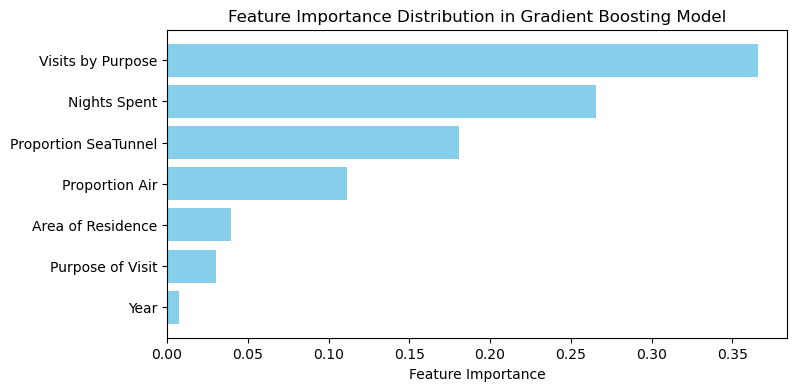

In [7]:
import pandas as pd
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import matplotlib.pyplot as plt
import numpy as np

# Load Data
data = TravelTrends_df

# Fill all numerical columns with 0 for the year 2020
numerical_columns = data.select_dtypes(include='number').columns
data.loc[data['Year'] == '2020', numerical_columns] = 0

# Filter out data to include only quarterly data (Q1, Q2, Q3, Q4) and exclude "World Total"
filtered_data = data[(data['Quarter'].isin(['Q1', 'Q2', 'Q3', 'Q4'])) & (data['Purpose of Visit'] != 'All visits')]

# Initialize the label encoder for 'Area of Residence' and 'Purpose of Visit'
label_encoder_residence = LabelEncoder()
label_encoder_purpose = LabelEncoder()

# Encode 'Area of Residence' and 'Purpose of Visit'
filtered_data['Area of Residence'] = label_encoder_residence.fit_transform(filtered_data['Area of Residence'])
filtered_data['Purpose of Visit'] = label_encoder_purpose.fit_transform(filtered_data['Purpose of Visit'])

# Feature Engineering: Create a proportion feature
filtered_data['Proportion Air'] = filtered_data['Number of visits by Air'] / filtered_data['Total Visits']
filtered_data['Proportion SeaTunnel'] = filtered_data['Number of visits by Sea and Tunnel'] / filtered_data['Total Visits']

# Fill any NaN values that might result from division by zero
filtered_data['Proportion Air'].fillna(0, inplace=True)
filtered_data['Proportion SeaTunnel'].fillna(0, inplace=True)

# Check if there are still NaN values
print("NaN values in dataset after filling:", filtered_data.isna().sum().sum())

# Define Features and Target without 'Total Visits'
features = ['Area of Residence', 'Nights Spent', 'Purpose of Visit', 
            'Visits by Purpose', 'Proportion Air', 'Proportion SeaTunnel', 'Year']
X = filtered_data[features]
y = filtered_data['Spending in millions']

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Ensure there are no remaining NaN values in X_scaled
if pd.isnull(X_scaled).sum().sum() > 0:
    print("There are still NaN values in the dataset.")
else:
    print("No NaN values found in the dataset.")

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)

# Fine-tuned Hyperparameter Tuning with RandomizedSearchCV
param_dist = {
    'n_estimators': [50, 100],
    'learning_rate': [0.01, 0.1],  # Learning rate to control the contribution of each tree
    'max_depth': [3, 5],  # Depth of each tree
    'min_samples_split': [10, 30],  # Minimum samples required to split a node
    'min_samples_leaf': [5, 15],  # Minimum samples required at each leaf node
    'max_features': ['sqrt']  # Maximum number of features considered for each split
}

gbr = GradientBoostingRegressor(random_state=42)
random_search = RandomizedSearchCV(estimator=gbr, param_distributions=param_dist, 
                                   n_iter=10, cv=3, verbose=2, n_jobs=-1, random_state=42)
random_search.fit(X_train, y_train)

# Best parameters from Randomized Search
best_gbr = random_search.best_estimator_

# Train the model on the training dataset
best_gbr.fit(X_train, y_train)

# Predict on the test set
y_test_pred = best_gbr.predict(X_test)

# Evaluate the Model on the Test Set
test_r2 = r2_score(y_test, y_test_pred)
test_rmse = mean_squared_error(y_test, y_test_pred, squared=False)
test_mae = mean_absolute_error(y_test, y_test_pred)
print("Test R^2:", test_r2)
print("Test RMSE:", test_rmse)
print("Test MAE:", test_mae)

# Predict for 2024 using the entire dataset
X_2024 = X.copy()
X_2024['Year'] = 2024  # Adjust Year for prediction
X_2024_scaled = scaler.transform(X_2024)
y_2024_pred = best_gbr.predict(X_2024_scaled)

# Aggregate Predictions by Area of Residence and Purpose of Visit
predictions_by_area_purpose = {}
for region in filtered_data['Area of Residence'].unique():
    for purpose in filtered_data['Purpose of Visit'].unique():
        region_name = label_encoder_residence.inverse_transform([region])[0]
        purpose_name = label_encoder_purpose.inverse_transform([purpose])[0]
        key = f"{region_name} - {purpose_name}"
        
        predictions_by_area_purpose[key] = y_2024_pred[
            (filtered_data['Area of Residence'] == region) & 
            (filtered_data['Purpose of Visit'] == purpose)].sum()

# Convert the predictions dictionary to a DataFrame for tabular output
df_predictions = pd.DataFrame(list(predictions_by_area_purpose.items()), columns=['Area and Purpose', 'Predicted Spending (in millions)'])

# Output the results in tabular form
print(df_predictions.head())
# Save the updated data to a new CSV file
output_path = 'C://Users/vaibh/OneDrive/Desktop/BUSINESSPROJECT/PredictedData_GBR.csv'
df_predictions.to_csv(output_path, index=False)

# Evaluate the Model on the Training Set
y_train_pred = best_gbr.predict(X_train)
train_r2 = r2_score(y_train, y_train_pred)
train_rmse = mean_squared_error(y_train, y_train_pred, squared=False)
train_mae = mean_absolute_error(y_train, y_train_pred)
print("Train R^2:", train_r2)
print("Train RMSE:", train_rmse)
print("Train MAE:", train_mae)

# Feature Importance Analysis
feature_importances = best_gbr.feature_importances_
features = np.array(['Area of Residence', 'Nights Spent', 'Purpose of Visit', 
                     'Visits by Purpose', 'Proportion Air', 'Proportion SeaTunnel', 'Year'])

# Sort the feature importances in descending order
sorted_idx = np.argsort(feature_importances)[::-1]

# Plot the feature importances
plt.figure(figsize=(8, 4))
plt.barh(features[sorted_idx], feature_importances[sorted_idx], color='skyblue')
plt.xlabel('Feature Importance')
plt.title('Feature Importance Distribution in Gradient Boosting Model')
plt.gca().invert_yaxis()  # Invert y-axis to show the most important feature at the top
plt.show()
